# TDI Challenge 2019 by Sungryong Hong. 

> This notebook will show how I have solved the problems in *Section 1 and 2*. 

## 1. NYPD Motor Vehicle Collision Data

In [1]:
# basic modules 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.spatial import cKDTree


# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

### 1.1 Read and Explore the data

In [2]:
# Read data
rawdf = pd.read_csv("./NYPD_Motor_Vehicle_Collisions.csv", low_memory=False)

In [3]:
rawdf.head(3)

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,04/28/2019,0:00,BROOKLYN,11208,40.685050,-73.875950,"(40.68505, -73.87595)",NaN,NaN,126 CHESTNUT STREET,...,Passing Too Closely,NaN,NaN,NaN,4122662,Sedan,NaN,NaN,NaN,NaN
1,04/28/2019,0:00,QUEENS,11419,40.690490,-73.816086,"(40.69049, -73.816086)",103 AVENUE,130 STREET,NaN,...,Unspecified,NaN,NaN,NaN,4121710,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,04/28/2019,0:00,NaN,NaN,40.699955,-73.986820,"(40.699955, -73.98682)",JAY STREET,SANDS STREET,NaN,...,Unspecified,NaN,NaN,NaN,4122602,Sedan,Bike,NaN,NaN,NaN


In [4]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486228 entries, 0 to 1486227
Data columns (total 29 columns):
DATE                             1486228 non-null object
TIME                             1486228 non-null object
BOROUGH                          1041434 non-null object
ZIP CODE                         1041259 non-null object
LATITUDE                         1299800 non-null float64
LONGITUDE                        1299800 non-null float64
LOCATION                         1299800 non-null object
ON STREET NAME                   1200762 non-null object
CROSS STREET NAME                1010085 non-null object
OFF STREET NAME                  193313 non-null object
NUMBER OF PERSONS INJURED        1486211 non-null float64
NUMBER OF PERSONS KILLED         1486197 non-null float64
NUMBER OF PEDESTRIANS INJURED    1486228 non-null int64
NUMBER OF PEDESTRIANS KILLED     1486228 non-null int64
NUMBER OF CYCLIST INJURED        1486228 non-null int64
NUMBER OF CYCLIST KILLED        

In [5]:
rawdf.columns.values

array(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'UNIQUE KEY', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'], dtype=object)

### 1.2 Get `timestamp` from `DATE` and `TIME`

#### Testing whether `str` works for the conversions 

In [6]:
rawdf[:5].apply(lambda row: pd.to_datetime(str(row[0])+' '+str(row[1])) , axis=1)

0   2019-04-28 00:00:00
1   2019-04-28 00:00:00
2   2019-04-28 00:00:00
3   2019-04-28 00:01:00
4   2019-04-28 00:05:00
dtype: datetime64[ns]

#### Ok. Let's make a `datetime` column 

In [7]:
%%time
rawdf['datetime'] = rawdf.apply(lambda row: pd.to_datetime(str(row[0])+' '+str(row[1])) , axis=1)

CPU times: user 7min 10s, sys: 2.76 s, total: 7min 13s
Wall time: 7min 13s


> It takes longer than I thought. 

>However, I will keep sticking to Pandas, not Spark's Dataframe, for easy and dirty calculations

In [29]:
rawdf['datetime'][:5]

0   2019-04-28 00:00:00
1   2019-04-28 00:00:00
2   2019-04-28 00:00:00
3   2019-04-28 00:01:00
4   2019-04-28 00:05:00
Name: datetime, dtype: datetime64[ns]

> Let's save this raw dataframe as a parquet table for future conveinence. We can start with loading this table afterwards, not reading the csv. 

In [13]:
import pyarrow as pa
import pyarrow.parquet as pq

In [14]:
pq.write_table(pa.Table.from_pandas(rawdf), 'rawNYPDdata.parquet.snappy', compression='snappy')
#rawdf = pq.read_table('rawNYPDdata.parquet.snappy').to_pandas()

### 1.3 Take the data `datetime < 2019-01-01` and Solve the problems in Section 1

In [31]:
%%time
df = rawdf[rawdf.datetime < '2019-01-01']

CPU times: user 152 ms, sys: 84.9 ms, total: 237 ms
Wall time: 235 ms


In [32]:
len(df.index)

1420242

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1420242 entries, 121 to 1486227
Data columns (total 30 columns):
DATE                             1420242 non-null object
TIME                             1420242 non-null object
BOROUGH                          998752 non-null object
ZIP CODE                         998596 non-null object
LATITUDE                         1239143 non-null float64
LONGITUDE                        1239143 non-null float64
LOCATION                         1239143 non-null object
ON STREET NAME                   1150474 non-null object
CROSS STREET NAME                977241 non-null object
OFF STREET NAME                  177631 non-null object
NUMBER OF PERSONS INJURED        1420225 non-null float64
NUMBER OF PERSONS KILLED         1420211 non-null float64
NUMBER OF PEDESTRIANS INJURED    1420242 non-null int64
NUMBER OF PEDESTRIANS KILLED     1420242 non-null int64
NUMBER OF CYCLIST INJURED        1420242 non-null int64
NUMBER OF CYCLIST KILLED         

#### (Q) What is the total number of persons injured in the dataset (up to December 31, 2018?)

In [34]:
df['NUMBER OF PERSONS INJURED'][:5]

121     1.0
564     0.0
7206    0.0
7473    0.0
7815    0.0
Name: NUMBER OF PERSONS INJURED, dtype: float64

In [35]:
df['NUMBER OF PERSONS INJURED'].sum()

368034.0

#### (Q) What proportion of collisions in 2016 resulted in injury or death of a cyclist?

> It is kind of vague(?) what you are asking(?). I will calculate the ratio (proportion) of `cyclist-related` accidents in 2016 to `the total` accidents in 2016. 

In [37]:
df2016 = df[(df.datetime >= '2016-01-01') & (df.datetime < '2017-01-01')]

In [41]:
totalAccident2016 = len(df2016.index)

In [42]:
totalAccident2016

229788

In [43]:
dfcyclist2016 = df2016[(df2016['NUMBER OF CYCLIST INJURED'] > 0) | (df2016['NUMBER OF CYCLIST KILLED'] > 0)]

In [46]:
dfcyclist2016[['NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED']].describe()

,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED
count,4976.000000,4976.000000
mean,1.005627,0.004019
std,0.120169,0.063277
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,3.000000,1.000000


In [48]:
len(dfcyclist2016.index)

4976

In [49]:
print np.double(len(dfcyclist2016.index))/np.double(totalAccident2016)

0.021654742632339373


#### (Q) Brooklyn in BOROUGH

> What proportion of all collisions in 2016 occured in Brooklyn? Only consider entries with a non-null value for BOROUGH.

In [62]:
df2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229788 entries, 515403 to 758247
Data columns (total 30 columns):
DATE                             229788 non-null object
TIME                             229788 non-null object
BOROUGH                          153289 non-null object
ZIP CODE                         153244 non-null object
LATITUDE                         192620 non-null float64
LONGITUDE                        192620 non-null float64
LOCATION                         192620 non-null object
ON STREET NAME                   176684 non-null object
CROSS STREET NAME                132004 non-null object
OFF STREET NAME                  47229 non-null object
NUMBER OF PERSONS INJURED        229787 non-null float64
NUMBER OF PERSONS KILLED         229787 non-null float64
NUMBER OF PEDESTRIANS INJURED    229788 non-null int64
NUMBER OF PEDESTRIANS KILLED     229788 non-null int64
NUMBER OF CYCLIST INJURED        229788 non-null int64
NUMBER OF CYCLIST KILLED         229788 non-

In [60]:
len(df2016.index)

229788

In [61]:
df2016['BOROUGH'].count()

153289

In [63]:
grouped = df2016.groupby('BOROUGH')

In [64]:
grouped.groups.keys()

['BRONX', 'BROOKLYN', 'STATEN ISLAND', 'MANHATTAN', 'QUEENS']

In [67]:
len(grouped.get_group('BROOKLYN'))

47461

In [68]:
print 47461.0/153289.0

0.309617780793


#### (Q) The number of cars in accidents for each zip code in 2016

> Obtain the number of vehicles involved in each collision in 2016. Group the collisions by zip code and compute the sum of all vehicles involved in collisions in each zip code, then report the maximum of these values.

> Explore **vehicle**-related columns

In [51]:
df2016[['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3',\
        'VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']][:5]

,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
515403,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
515492,PICK-UP TRUCK,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
515538,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
515584,AMBUL,NaN,NaN,NaN,NaN
515789,PASSENGER VEHICLE,NaN,NaN,NaN,NaN


In [52]:
df2016[['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3',\
        'CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5']][:5]

,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5
515403,Unspecified,NaN,NaN,NaN,NaN
515492,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN
515538,Unspecified,NaN,NaN,NaN,NaN
515584,Unspecified,NaN,NaN,NaN,NaN
515789,Unspecified,NaN,NaN,NaN,NaN


> Testing `.isnull()` and `notnull()`, and check whether `boolean` can be treated as `integer` 

In [71]:
df2016['VEHICLE TYPE CODE 2'][:5].isnull()

515403     True
515492    False
515538     True
515584     True
515789     True
Name: VEHICLE TYPE CODE 2, dtype: bool

In [72]:
df2016['VEHICLE TYPE CODE 2'][:5].isnull().sum()

4

In [74]:
df2016['VEHICLE TYPE CODE 2'][:5].notnull()

515403    False
515492     True
515538    False
515584    False
515789    False
Name: VEHICLE TYPE CODE 2, dtype: bool

In [75]:
df2016['VEHICLE TYPE CODE 2'][:5].notnull().sum()

1

> Ok. The below can count the number of vehicles in each accident

In [77]:
df2016[['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3',\
        'VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']][:5]\
    .apply(lambda row: row.notnull().sum(),axis=1)

515403    1
515492    2
515538    1
515584    1
515789    1
dtype: int64

In [78]:
df2016['numVehicles'] = df2016[['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2',\
                                'VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4',\
                                'VEHICLE TYPE CODE 5']]\
                        .apply(lambda row: row.notnull().sum(),axis=1)

/home/shong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
df2016['numVehicles'].describe()

count    229788.000000
mean          2.131852
std           0.893740
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           5.000000
Name: numVehicles, dtype: float64

In [82]:
df2016.columns.values

array(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'UNIQUE KEY', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5', 'datetime', 'numVehicles'], dtype=object)

In [86]:
# Pandas Series
psCrashes = df2016[['ZIP CODE','numVehicles']].groupby('ZIP CODE').sum()

In [91]:
psCrashes.sort_values('numVehicles',ascending=False).head(5)

,numVehicles
ZIP CODE,
11207,5703
11101,4375
11234,4283
11434,4181
11203,4142


> The answer is `5703` at `ZIP = 11207`

#### (Q) Linear Trend of the number of Car Crashes 

> Consider the total number of collisions each year from 2013-2018. Is there an apparent trend? Fit a linear regression for the number of collisions per year and report its slope.

In [97]:
df.columns.values

array(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'UNIQUE KEY', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5', 'datetime'], dtype=object)

In [98]:
df[:2].datetime.dt.year

121    2018
564    2018
Name: datetime, dtype: int64

In [130]:
# Pandas Series : the number of accidents by year
psNumAccidents = df['datetime'].groupby(df.datetime.dt.year).count()

In [131]:
psNumAccidents

datetime
2012    100541
2013    203729
2014    206030
2015    217692
2016    229788
2017    230997
2018    231465
Name: datetime, dtype: int64

In [132]:
psNumAccidents.index.values

array([2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [133]:
psNumAccidents.values

array([100541, 203729, 206030, 217692, 229788, 230997, 231465])

> Oh.. from 2013 .., not 2012

In [134]:
psNumAccidents = psNumAccidents[1:]

In [135]:
psNumAccidents.index.values

array([2013, 2014, 2015, 2016, 2017, 2018])

In [136]:
psNumAccidents.values

array([203729, 206030, 217692, 229788, 230997, 231465])

> a simple `scipy` package

In [137]:
from scipy import stats

In [138]:
slope, intercept, r_value, p_value, std_err =\
stats.linregress(np.double(psNumAccidents.index.values),np.double(psNumAccidents.values))

In [139]:
[slope, intercept, r_value, p_value, std_err]

[6447.914285714285,
 -12775821.076190475,
 0.9457694166820132,
 0.004331689366288895,
 1107.3166194825742]

In [140]:
# model prediction
ymodel = 6447.914285714285 * np.double(psNumAccidents.index.values) -12775821.076190475

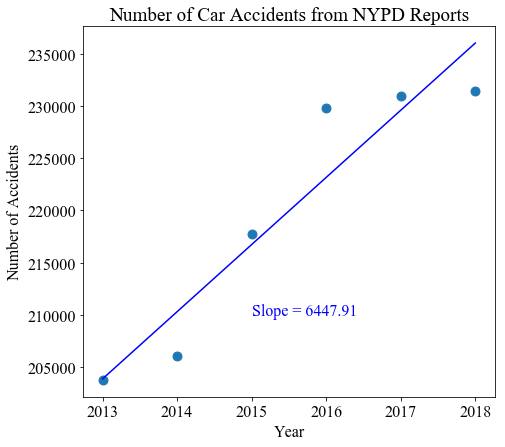

In [141]:
# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(7,6.2))

#plt.axis([0,lenmax,0,1.0])
plt.title("Number of Car Accidents from NYPD Reports")
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r'Number of Accidents')
plt.xlabel(r'Year')
plt.scatter(psNumAccidents.index.values,psNumAccidents.values,s=80)
plt.plot(psNumAccidents.index.values,ymodel,color='b')
plt.text(2015,210000,'Slope = 6447.91',color='b')


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#fig.savefig("car-accidents.eps")
plt.show()


#### (Q) Winter vs. Multple Car Crashes in 2017

> Do winter driving conditions lead to more multi-car collisions? Compute the rate of multi car collisions as the proportion of the number of collisions involving 3 or more cars to the total number of collisions for each month of 2017. Calculate the chi-square test statistic for testing whether a collision is more likely to involve 3 or more cars in January than in May

In [142]:
# sub-dateframe for 2017 
df2017 = df[(df.datetime >= '2017-01-01') & (df.datetime < '2018-01-01')]

In [143]:
df2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230997 entries, 297392 to 528484
Data columns (total 30 columns):
DATE                             230997 non-null object
TIME                             230997 non-null object
BOROUGH                          142946 non-null object
ZIP CODE                         142896 non-null object
LATITUDE                         217075 non-null float64
LONGITUDE                        217075 non-null float64
LOCATION                         217075 non-null object
ON STREET NAME                   177530 non-null object
CROSS STREET NAME                109967 non-null object
OFF STREET NAME                  53018 non-null object
NUMBER OF PERSONS INJURED        230986 non-null float64
NUMBER OF PERSONS KILLED         230981 non-null float64
NUMBER OF PEDESTRIANS INJURED    230997 non-null int64
NUMBER OF PEDESTRIANS KILLED     230997 non-null int64
NUMBER OF CYCLIST INJURED        230997 non-null int64
NUMBER OF CYCLIST KILLED         230997 non-

In [144]:
%%time
# Count the nubmer of crashed vehicles in each accident, as we have done before
df2017['numVehicles'] = df2017[['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2',\
                                'VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4',
                                'VEHICLE TYPE CODE 5']]\
                            .apply(lambda row: row.notnull().sum(),axis=1)


CPU times: user 40.4 s, sys: 161 ms, total: 40.6 s
Wall time: 40.6 s


/home/shong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


> The running time is just OK. We do not need `PySpark`. 

In [145]:
grouped2017 = df2017[['datetime','numVehicles']].groupby(df2017.datetime.dt.month)

In [147]:
grouped2017.groups.keys()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [148]:
dfJan = grouped2017.get_group(1)

In [149]:
dfJan.head(5)

,datetime,numVehicles
506494,2017-01-28 13:10:00,2
507286,2017-01-26 18:10:00,1
507551,2017-01-26 19:30:00,2
508175,2017-01-25 03:50:00,2
508317,2017-01-24 09:15:00,2


In [150]:
dfMay = grouped2017.get_group(5)

In [151]:
[len(dfJan),len(dfMay)]

[17551, 21012]

In [152]:
[len(dfJan[dfJan.numVehicles > 2]),len(dfMay[dfMay.numVehicles > 2])]

[6212, 1136]

In [153]:
# the fraction of multiple (>2 or >=3) cars accidents to the total accidents
fracJan = 6212.0/17551.0
fracMay = 1136.0/21012.0

In [154]:
[fracJan, fracMay]

[0.3539399464417982, 0.05406434418427565]

In [156]:
print "chisquare = ", ((fracJan-fracMay)**2/fracMay)

chisquare =  1.66330283269


> Even from naive values (35% in Jan and 5% in May), **there are more multple-car-crashes in winter**. In my field of Astronomy and Astrophysics, we generally use the Kolmogorov Smirnov test. 

In [158]:
from scipy.stats import ks_2samp

In [162]:
dval, pval = ks_2samp(np.double(dfJan.numVehicles.values), np.double(dfMay.numVehicles.values))

In [163]:
[dval, pval]

[0.3040397849337455, 0.0]

> what? numerically p = `zero` in the `float` precision? The patterns in multiple collions are statistically very very different between Jan and May.

#### (Q) Accidents related to Alcohol

> For each borough, compute the number of accidents per capita involving alcohol in 2017. 
Report the highest rate among the 5 boroughs. Use populations 
as given by https://en.wikipedia.org/wiki/Demographics_of_New_York_City.

In [203]:
# sub-dateframe for 2017 
df2017 = df[(df.datetime >= '2017-01-01') & (df.datetime < '2018-01-01')]

In [204]:
df2017[['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3',\
        'CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5']][:5]

,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5
297392,Unspecified,Unspecified,NaN,NaN,NaN
297452,Unspecified,NaN,NaN,NaN,NaN
297453,Unspecified,NaN,NaN,NaN,NaN
297454,Reaction to Uninvolved Vehicle,Unspecified,NaN,NaN,NaN
297455,Driver Inexperience,Unspecified,NaN,NaN,NaN


> Quick and Dirty implementation to find `alcohol` in *contributing factors* 

In [205]:
df2017[['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2',\
        'CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4',\
        'CONTRIBUTING FACTOR VEHICLE 5']][:5]\
    .apply(lambda row: (str(row[0])+str(row[1])+str(row[2])+str(row[3])+str(row[4])).lower() ,axis=1)

297392                      unspecifiedunspecifiednannannan
297452                              unspecifiednannannannan
297453                              unspecifiednannannannan
297454    reaction to uninvolved vehicleunspecifiednanna...
297455              driver inexperienceunspecifiednannannan
dtype: object

In [206]:
%%time
df2017['str_contribute'] =\
df2017[['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2',\
        'CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4',\
        'CONTRIBUTING FACTOR VEHICLE 5']]\
    .apply(lambda row: (str(row[0])+str(row[1])+str(row[2])+str(row[3])+str(row[4])).lower() ,axis=1)

CPU times: user 13.6 s, sys: 104 ms, total: 13.7 s
Wall time: 13.7 s


/home/shong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [207]:
df2017['str_contribute'][:10]

297392                      unspecifiedunspecifiednannannan
297452                              unspecifiednannannannan
297453                              unspecifiednannannannan
297454    reaction to uninvolved vehicleunspecifiednanna...
297455              driver inexperienceunspecifiednannannan
297456                      unspecifiedunspecifiednannannan
297457                              unspecifiednannannannan
297458    passing or lane usage improperoutside car dist...
297459                      unspecifiedunspecifiednannannan
297460                              unspecifiednannannannan
Name: str_contribute, dtype: object

In [208]:
df2017.columns.values

array(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'UNIQUE KEY', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5', 'datetime', 'str_contribute'], dtype=object)

In [211]:
df2017[['str_contribute']][:10].apply(lambda row: row[0].find('pecified'), axis=1)

297392     3
297452     3
297453     3
297454    33
297455    22
297456     3
297457     3
297458    -1
297459     3
297460     3
dtype: int64

In [213]:
%%time
df2017['flag_alcohol'] =\
df2017[['str_contribute']].apply(lambda row: row[0].find('alcohol'), axis=1)

CPU times: user 3.66 s, sys: 32.5 ms, total: 3.7 s
Wall time: 3.69 s


/home/shong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [214]:
len(df2017[df2017.flag_alcohol > -1])

2675

In [218]:
dfAlcohol = df2017[df2017.flag_alcohol > -1]

In [219]:
groupedAlcohol = dfAlcohol.groupby('BOROUGH')

In [220]:
groupedAlcohol.groups.keys()

['BRONX', 'BROOKLYN', 'STATEN ISLAND', 'MANHATTAN', 'QUEENS']

In [223]:
numAlcoholAcc =\
np.double(\
[len(groupedAlcohol.get_group('BRONX')),\
 len(groupedAlcohol.get_group('BROOKLYN')),\
 len(groupedAlcohol.get_group('STATEN ISLAND')),\
 len(groupedAlcohol.get_group('MANHATTAN')),\
 len(groupedAlcohol.get_group('QUEENS'))])

In [224]:
numAlcoholAcc

array([274., 602., 100., 259., 512.])

In [225]:
# number of populations 2017 from wikipedia
numPop = np.double([1471160.0, 2648771.0, 479458.0, 1664727.0, 2358582.0])

In [228]:
numAlcoholAcc/numPop

array([0.00018625, 0.00022728, 0.00020857, 0.00015558, 0.00021708])

In [229]:
(numAlcoholAcc/numPop).max()

0.00022727521556223623

> `0.00022727521556223623` for 'BROOKLYN'

#### (Q) The spatial density of car accidents in 2017 

> We can use collision locations to estimate the areas of the zip code regions. Represent each as an ellipse with semi-axes given by a single standard deviation of the longitude and latitude. For collisions in 2017, estimate the number of collisions per square kilometer of each zip code region. Considering zipcodes with at least 1000 collisions, report the greatest value for collisions per square kilometer. Note: Some entries may have invalid or incorrect (latitude, longitude) coordinates. Drop any values that are invalid or seem unreasonable for New York City.

In [230]:
# reassign the 2017 dataframe
df2017 = df[(df.datetime >= '2017-01-01') & (df.datetime < '2018-01-01')]

In [231]:
df2017.columns.values

array(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'UNIQUE KEY', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5', 'datetime'], dtype=object)

In [232]:
df2017[['LONGITUDE','LATITUDE']].describe()

,LONGITUDE,LATITUDE
count,217075.000000,217075.000000
mean,-73.919369,40.707421
std,2.536927,0.842007
min,-201.237060,0.000000
25%,-73.976000,40.667934
50%,-73.927284,40.722286
75%,-73.865405,40.771656
max,0.000000,41.126150


> Plot the spatial positions and see how many points have abnormal positions

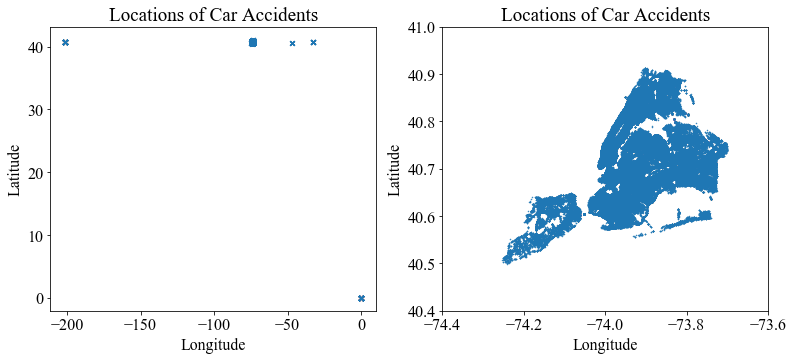

In [249]:
# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(11,5))


plt.subplot(121)
plt.title("Locations of Car Accidents")
#plt.axis([0,lenmax,0,1.0])
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r'Latitude')
plt.xlabel(r'Longitude')
plt.scatter(df2017['LONGITUDE'].values,df2017['LATITUDE'].values,marker='x',s=20)


plt.subplot(122)
plt.title("Locations of Car Accidents")
plt.axis([-74.4,-73.6,40.4,41])
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel(r'Latitude')
plt.xlabel(r'Longitude')
plt.scatter(df2017['LONGITUDE'].values,df2017['LATITUDE'].values,marker='.',s=1)
#plt.plot(psNumAccidents.index.values,ymodel,color='b')
#plt.text(2015,210000,'Slope = 6447.91',color='b')




plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#fig.savefig("accidents-loccations.eps")
plt.show()

In [253]:
locdf =\
df2017[(df2017.LONGITUDE > -74.4) & (df2017.LONGITUDE < -73.6)\
       & (df2017.LATITUDE < 41.0) & (df2017.LATITUDE > 40.4)]

In [254]:
locdf[['LONGITUDE','LATITUDE']].describe()

,LONGITUDE,LATITUDE
count,216908.000000,216908.000000
mean,-73.921092,40.724671
std,0.088014,0.079814
min,-74.253006,40.499310
25%,-73.975980,40.667976
50%,-73.927320,40.722305
75%,-73.865470,40.771748
max,-73.700584,40.912884


> Now, all coordinates are in sanity. 

In [255]:
locdf.columns.values

array(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'UNIQUE KEY', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5', 'datetime'], dtype=object)

In [256]:
locgroup = locdf[['ZIP CODE', 'LATITUDE', 'LONGITUDE','datetime']].groupby('ZIP CODE')

In [258]:
locgroup.groups.keys()[:5]

['10065', '10069', '10012', '10453', '10452']

In [261]:
locgroup.get_group('10065').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 297519 to 528177
Data columns (total 4 columns):
ZIP CODE     796 non-null object
LATITUDE     796 non-null float64
LONGITUDE    796 non-null float64
datetime     796 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 31.1+ KB


In [286]:
locresult = pd.DataFrame(locgroup.datetime.count())

In [287]:
locresult.columns=['total']

In [288]:
locresult[:5]

,total
ZIP CODE,
10000,73
10001,1656
10002,1607
10003,922
10004,200


In [289]:
locresult['stdlon'] = locgroup['LONGITUDE'].std().values

In [291]:
locresult['stdlat'] = locgroup['LATITUDE'].std().values

In [292]:
locresult.head(3)

,total,stdlon,stdlat
ZIP CODE,,,
10000,73,0.005024,0.006955
10001,1656,0.005335,0.003272
10002,1607,0.006887,0.004739


In [306]:
locresult = locresult[locresult.total > 999]

In [307]:
locresult.head(3)

,total,stdlon,stdlat
ZIP CODE,,,
10001,1656,0.005335,0.003272
10002,1607,0.006887,0.004739
10011,1113,0.004514,0.004031


> I assume: `Earth Radius = 6,371 km`. 

> Spatial distance from $\Delta_{lat}$ = Radius $\times \Delta_{lat}$

> Spatial distance from $\Delta_{lon}$ = Radius $\times \cos(lat_0) \times \Delta_{lon}$. We use $lat_0 = 40.724671$ (deg). From Degree to Radian, `degtorad = np.pi / 180.`

In [308]:
degtorad = np.pi / 180.

In [309]:
earthR = 6371.0

In [310]:
locresult[:5].apply(lambda row: earthR*row[2]*degtorad,axis=1)

ZIP CODE
10001    0.363816
10002    0.526944
10011    0.448175
10013    0.305264
10016    0.362845
dtype: float64

In [311]:
locresult[:5].apply(lambda row: earthR*np.cos(40.724671*degtorad)*row[1]*degtorad,axis=1)

ZIP CODE
10001    0.449613
10002    0.580401
10011    0.380415
10013    0.366885
10016    0.335175
dtype: float64

In [312]:
locresult[:5].apply(lambda row: np.double(row[0])/\
                    (earthR*np.cos(40.724671*degtorad)*row[1]*degtorad\
                     *earthR*row[2]*degtorad*np.pi),axis=1)

ZIP CODE
10001    3222.475593
10002    1672.529772
10011    2077.974268
10013    4280.260521
10016    3910.284091
dtype: float64

In [313]:
# we can optimize the redundant calculations, earthR*earthR*np.pi to a single number. 
# But, since we have only a small number of rows, let's do it without thinking about any optimization of computing.
locresult['densityAccidents'] = \
locresult.apply(lambda row:\
                np.double(row[0])/\
                (np.pi*earthR*np.cos(40.724671*degtorad)*row[1]*degtorad*earthR*row[2]*degtorad),axis=1)

In [315]:
locresult.sort_values('densityAccidents',ascending=False).head(10)

,total,stdlon,stdlat,densityAccidents
ZIP CODE,,,,
10022,1383,0.004003,0.002289,5126.768648
10036,1638,0.005027,0.002277,4861.222495
10013,1506,0.004354,0.002745,4280.260521
10016,1494,0.003977,0.003263,3910.284091
10001,1656,0.005335,0.003272,3222.475593
10018,1384,0.008062,0.002746,2123.704515
10011,1113,0.004514,0.004031,2077.974268
10459,1028,0.003992,0.004504,1941.882641
11226,1864,0.005391,0.006218,1888.913996


> The answer is `5126.768648` for `ZIP = 10022`